<a href="https://colab.research.google.com/github/paulodowd/EMATM0054_53/blob/main/Labsheets/Core/L2_LineSensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labsheet 3: Line Sensors

In previous lab sessions, you have:
- Seen the standard Arduino sketch, which has the structure of setup() and loop() routines.
- Experimented with Arduino Example sketches
- Uploaded sketches to your robot.
- Experimented with Serial commands to view debug output from your code.
- Controlled the power of the two motors with analogWrite()
- Developed your own motor `class`, neatly encapsulating the code for the motors.

This labsheet will serve as a good model for how we might investigate a new sensor, develop code for the sensor, and then validate the operation.

This labsheet has two different approaches. It is possible to complete only **Approach 1** and then continue to the next labsheet.  If you want to do this, it is recommended to also consider reading the section **Multi-tasking with Millis()**, and completing **Exercise 6** in this labsheet to build your own Line Sensor class.

On the 3Pi+ there are 5 of sensors facing toward the ground surface. These are visible beneath the robot, as annotated in the following image:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_BottomAnnotated.png?raw=true">
<br>
</p>

For basic operation of following a line, the 3 central sensors are most useful.  On the robot and in the documentation, these are labelled `DN2`, `DN3` and `DN4`.  The exercises in this labsheet omit the left-most (`DN1`) and right-most (`DN5`) sensors to simplify the learning process and tuition. After this labsheet, you might want to adapt your code to include these two further sensors.

In this labsheet we will learn to operate the sensors for line detection.  There are actually **2 ways we can operate these sensors**.  
- **Approach 1**: Using the `Analog to Digital Converter` (ADC) to measure the voltage passing through the sensor phototransistor.
- **Approach 2**: Using an internal timer to measure the discharge of a capacitor in the sensor.

Either approach can be used to complete Assessment 1.







<hr><br><br><br><br>



# Approach 1: Using the Analogue-to-Digital Converter (ADC)

The <a href="https://www.pololu.com/docs/0J83/5.5">official documentation for the Pololu 3Pi+</a> describes the second approach in this labsheet to read the sensors (using an internal timer to measure the discharge of the sensor capacitor, next section of this Labsheet).  However, it is possible to set some special configuration within the microcontroller to allow for a simpler sensor reading operation using the `Analog-to-Ditigal Converter` (ADC).   This is not the way Pololu appeared to have intended when designing the sensors and circuitry.

In Arduino, reading an analogue voltage is almost as simple as using one line of code: `analogRead()`.  If we can get this to work it will be very convenient, and also potentially a lot quicker.  



```c
  // Somewhere to store the result
  int my_adc_read;

  // read the sensor, attached to pin 'A0'
  my_adc_read = analogRead(A0);
```



When calling this `analogRead()`, an internal peripheral called the `ADC` will be instructed to operate.  The ADC will attempt to compare the voltage on a specified pin of the microcontroller against a reference voltage source.  We can only use the `ADC` on specific pins, and these are labelled within Arduino as `A0`, `A1`, `A2`, etc.  Within our 3Pi+, the reference voltage is configured as the 5volt supply by default.  So the next logical step is to find out which pins the line sensors are connected to.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_PololuPinAssignments_LineBump.png?raw=true">
</p>

The <a href="https://www.pololu.com/docs/0J83/5.9">Pololu documentation on pin assignment</a> lists the following:
- `A11`, Line Sensor 1 (DN1, leftmost)
- `A0`, Line Sensor 2 (DN2)
- `A2`, Line Sensor 3 (DN3, centre)
- `A3`, Line Sensor 4 (DN4)
- `A4`, Line Sensor 5 (DN5, rightmost)

In the above, `A11`, `A0` (etc) are Arduino specified pin names.  These are used as a type of "find and replace" so that the code you write within Arduino could be used on different microcontrollers.  This is why it is important that you select the correct `Board` (for us, Arduino Leonardo) when using the Arduino IDE.  The Arduino IDE will take `A0` (for example) and map it to the actual hardware pin (`PF7`, "port F bit 7", <a href="https://www.pololu.com/docs/0J83/5.9">according to the Pololu documentation</a>).  Sometimes, you will see that a single pin will have more than one Arduino pin name.  As above, `A0` is also referred to as `18` - here, a good general rule is to use the `An` pin names when reading analogue pins, and otherwise use the numbered names (e.g. `18`) for all other digital operations.

If we go ahead and try to make an `analogRead()` of the line sensors it won't work.  You could try the following code:

```c

// The pin used to activate the IR LEDs
#define EMIT_PIN 11

void setup() {
   
   // configure the central line sensor pin
   // as input.
   pinMode(A2, INPUT);

   // Configure the EMIT pin as output and
   // high.  This will active some infra-red
   // (IR) LEDs for our sensors to read.
   pinMode( EMIT_PIN, OUTPUT );
   digitalWrite( EMIT_PIN, HIGH );

   // Configure the Serial port
   Serial.begin(9600);

}

void loop() {

   // A variable to save a reading
   int dn3;
   
   // Use ADC, assign result to variable
   dn3 = analogRead(A2);
   
   // Report back to computer over Serial
   Serial.print( dn3 );
   Serial.print( "\n" );

   delay(100);
}

```

You should find on Serial Monitor the reported values:

```
0
0
0
0
```

Why is this?  We can find the electronic schematic on the Pololu website (<a href="https://www.pololu.com/product/4975/resources">available here</a>) to try to understand why:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_BumpSchematic.png?raw=true">
<br>
</p>

The above is actually for the bump sensors, but they are electronically very similar to the line sensors, and provide a simpler schematic to inspect.  The leftmost portion with components `D9` and `D10` is the emitter circuit, which will provide the infra-red (IR) light to detect.  In the above, let's consider the middle section of the schematic, looking at each label:
- **5V**: this is the supply voltage shared with the 3Pi+ devices.
- **C53**: this is a capacitor, a bit like a tiny battery that can be charged and discharged.
- **Q10**: this is a photo-transistor.  It is a bit like a switch or valve that goes between `on` and `off`, determined by the amount of light hitting it (indicated by the little arrows pointing toward it).
- **R52**: this is a resistor, and will restrict the amount of current (flow) through the microcontroller, providing it some protection.
- **BUMPL**: this is the pin label used in the electronic schematic - another different label!  This can be matched up on page 1 of the schematic to D4, then PD4 of the microcontroller - an ADC pin.  Sometimes we have to do some detective work.
- ⏚ : this is the "ground" symbol, which is equivalent to 0 volts, and will complete the electronic circuits.

What we want to do is to measure the voltage received into `BUMPL` through `R52`.  What we want is to be able to sample the voltage between `C53` and `Q10` as if it was a <a href="https://studymind.co.uk/notes/potential-dividers/">potential divider</a>, but in the default configuration we cannot do it.

At the moment, when the 3Pi+ is powered on, the two sides of the capacitor
accumulate their respective charge, reach an equilibrium and becomes "fully charged".  Once this has happened, the capacitor appears to have the same voltage as the supply voltage (5v) - so between the 5v supply and `C53` there is no potential difference.  Because there is no potential difference, the capacitor `C53` ends up "blocking" the 5V source, from the point of view of `BUMPL`.   Therefore, `BUMPL` is only measuring ground (0V, ⏚) through `Q10`.  

To achieve a potential divider circuit, we can actually tell the Arduino to activate some internal circuitry (<a href="https://docs.arduino.cc/learn/microcontrollers/digital-pins/#pullup-resistors-with-pins-configured-as-input">in the Arduino reference here</a>).  Our example code becomes:

```c
//
// Example code to read A2 (line sensor DN3),
// using the ADC.
//

// The pin used to activate the IR LEDs
#define EMIT_PIN 11

void setup() {
   
   // configure the central line sensor pin
   // as input, and also activate the
   // internal pull-up resistor.
   pinMode(A2, INPUT_PULLUP);

   // Configure the EMIT pin as output and
   // high.  This will active some infra-red
   // (IR) LEDs for our sensors to read.
   pinMode( EMIT_PIN, OUTPUT );
   digitalWrite( EMIT_PIN, HIGH );

   // Configure the Serial port
   Serial.begin(9600);

}

void loop() {

   // A variable to save a reading
   int dn3;
   
   // Use ADC, assign result to variable
   dn3 = analogRead(A2);
   
   // Report back to computer over Serial
   Serial.print( dn3 );
   Serial.print( "\n" );

   delay(100);
}

```

Can you spot the difference?  The below diagram illustrates what this small adjustment to the code does electronically:

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_InputPullUpSchematic.png?raw=true">
</p>

On the left portion of the above schematic, the big yellow block labelled `Atmega32u4` is the microchip that is our microcontroller.  It has many more pins connect to other things, but these have been left out for simplicity.  Inside the `Atmega32u4` is illustrated the internal peripheral `Analogue-to-Digital Converter (ADC)`.  We can see that the same sensor circuit discussed earlier is attached to the point labelled `BUMPL`.

When we use the line of code `pinMode( A8, INPUT_PULLUP )` (for the circuit above, for example), we tell the microcontroller to activate a resistor inside the chip attached to pin `A8`, changing the overall electronic circuit.  This has been labelled `internal pullup resistor`.

The right portion of the above schematic is the same electronic ciruit, but reconfigured to discuss.  `C53` has been included, but let's ignore it carrying our assumption that it effectively blocks it's 5V source.  The internal pullup resistor is effectively bypassing the blocking capacitor `C53`.  Looking at the right portion, we can now see that a potential divider exists:
- The top half, following: `5V` through `internal pullup resistor`.
- The bottom half, `R52` and `Q10` connected in series to ground (`⏚`).  
- Our `BUMPL` pin is going to be measuring at the point between the two.

In this configuration, current can now flow from a 5V source to ground (⏚). through `internal pullup resistor`, `R52` and `Q10`.   The phototransistor `Q10` will now act like a variable resistor (changing it's resistance), restricting the current flow dependent on the light striking it.  Because we have current flowing, a complete circuit, we can now measure a changing analogue voltage at point `BUMPL`.


<hr><br><br><br><br>



## Exercise 1: Implementing and Evaluating an ADC read of the Line Sensors.

Using the example code provided above to configure and read the line sensors:
1. **Validate:** Before making changes to the example, check that you are able to upload the example to your 3Pi+ and view changing values on the Serial Monitor or Serial Plotter.
2. **Hypothesise:** The example code used `A2` to operate `DN3`, the central line sensor.  It used `pinMode()` to configure the pin, and `analogRead()` to take a measurement of the sensor.  
 - Reviewing the example code, identify the sequence of commands and their functionality.
 - Reviewing the example code, note which commands happen as initial `setup()` and which happen iteratively during `loop()`.  
 - Extend the example to read `DN2`, `DN3` and `DN4`.   This should be as simple as imitating the process used for `DN3`, with appropriate changes to pin names, etc.
3. **Validate:** After updating your code to read `DN2`, `DN3`, and `DN4`, update the `Serial.print()` commands to report the three sensor readings all on one line, seperated by commas.  Producing comma seperated values will allow you to use the Arduino Serial Plotter to visualise the data on a plot.  
 - You will need to make repating calls to `Serial.print();`, once for the variable and then again for the text string `","` - see example below.
 - For each set of data (probably, each `loop()`), remember to end with a newline (`"\n"`) - see example below.
 - **Note:** If you Serial Print anything other than comma seperated values, the Serial Plotter will not work properly (e.g. text will make it go weird)
 - **Note:** For Serial Plotter to work properly, you want to report the same number of variables on each line - this will become different coloured line plots.  (e.g., providing 3 comma seperated values, repeating line by line)

 ```c
 // Formatting for comma seperated values
 // Allows for Serial Plotter to visualise data.
 // We want output like:
 //  0,0,0
 // 20,4,5
 //  3,0,2 (etc)
 Serial.print( variable1 );
 Serial.print( "," );
 Serial.print( variable2 );
 Serial.print( "," );
 Serial.print( variable3 );
 Serial.print( "\n" );     // finish with a new line (\n)
```

4. **Research:** Capture the minimum, maxmimum and range of sensor values.  You will need to move your robot across white and black surfaces to capture the full range.  Remember, using global variables provides a persistent place in memory to store data.  Update the code with some global variables to:
 - Capture a maximum value for each sensor.  Consider, what initial value should you check against if you want to check for a maximum sensor value?
 - Capture a minimum value for each sensor.  Consider, what initial value should you check against if you want to check for a minimum sensor value?
 - Calculate the effective range for each sensor (the range of values that the sensor moves between)
 - **Validate:** Remove (or comment out) the previous `Serial.print()` commands which were reporting individual sensor readings. Instead, report the minimum, maximum and range of each sensor.  
 - **Note:** You will need to use an `if()` statement to compare a new reading against the current minimum or maximum you have saved.
 - **Note:** You can simply update your range calculation at every call of `loop()`.  
 - **Verify:** The Atmega32u4 microcontroller we are using has a 10-bit ADC.  Therefore, what percentage is your calculated effective range of the total range of values for the ADC?
 - **Verify:** Given your effective range of values for the sensor, how many binary bits of resolution is this approximately?
 - **Hypothesise:** What would happen if we used local variables (variables created within `loop()`) to store our minimum, maximum and range values?
 - **Hypothesise:** If we remove the robot from the black and white surface (e.g., we lift it up, or turn it upside down), are the minimum, maximum and range values better or worse, in terms of their appropriateness for Assessment 1?

5. **Research**: It is useful to plot and see how the sensor responds over a range of black to white values.  Using the greyscale test sheet (<a href="https://github.com/paulodowd/EMATM0054_53_23-24/tree/main/PrintableSheets/TestSheets">available here</a>), collect many samples from the sensors whilst it is placed on each grey strip.  Copy-and-paste your sensor readings into the below code cell to plot a graph of the sensor response.
 - **Note:** if you look at the code cell below, you will see that you will want to format your results like `[0, 36, 382, 350],` for each row of data, where the first column is a label of the greyscale strip value, and columns 2-4 are the sensor readings `DN2` to `DN4`.  Notice that, we want many readings for each greyscale strip, so that we can inspect if the sensor readings vary.
 - **Note:** It would be smart to simply use your 3Pi+ and `Serial.print()` commands to pre-format the text to copy from the Serial Monitor.  Previously we added commas to seperate values.  Follow a similar approach to achieve `[x,x,x,x],`.




<ipython-input-2-2b10f341a543>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append( pd.DataFrame( results_dn3 ) );
<ipython-input-2-2b10f341a543>:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append( pd.DataFrame( results_dn4 ) );


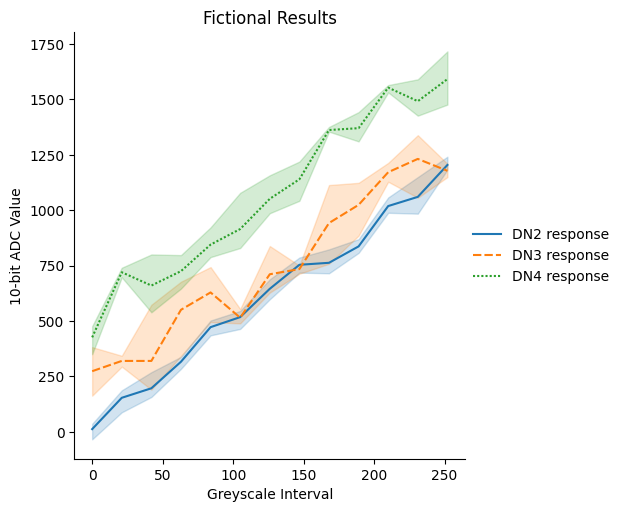

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a line plot with
# the region of error around the line.

# We use numpy to create an array of values
# Panda dataframes want arrays not lists.
import numpy as np

# We will use a library called Seaborn to
# make our plot for us, so we import it.
import seaborn as sns

# We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the array
# like the following.
# This allows multiple data entries per
# point on the x axis.
# Each row has columns as:
# [ <greyscale value>, <dn2>, <dn3>, <dn4> ]
results = np.array(
[
[0, 36, 382, 350],
[0, 34, 163, 476],
[0, 34, 275, 452],
[21, 185, 343, 697],
[21, 88, 322, 722],
[21, 187, 294, 740],
[42, 269, 196, 539],
[42, 163, 190, 640],
[42, 157, 573, 800],
[63, 284, 342, 797],
[63, 338, 677, 646],
[63, 326, 632, 731],
[84, 502, 495, 823],
[84, 435, 743, 922],
[84, 479, 648, 788],
[105, 545, 489, 837],
[105, 464, 501, 1078],
[105, 543, 554, 829],
[126, 649, 666, 986],
[126, 598, 628, 1157],
[126, 688, 838, 1010],
[147, 718, 739, 1156],
[147, 786, 713, 1219],
[147, 756, 750, 1042],
[168, 749, 954, 1354],
[168, 823, 758, 1355],
[168, 715, 1113, 1375],
[189, 869, 1123, 1357],
[189, 807, 885, 1310],
[189, 833, 1063, 1442],
[210, 1057, 1172, 1564],
[210, 988, 1128, 1563],
[210, 1010, 1213, 1531],
[231, 1149, 1338, 1590],
[231, 1046, 1056, 1458],
[231, 984, 1299, 1426],
[252, 1188, 1174, 1581],
[252, 1182, 1209, 1476],
[252, 1241, 1149, 1716]
 ] )

# Reformat the data using pandas to assign labels
# to each whole column of data.
# Use column 0 as the index (x axis)
# Use column n for each sensor value (y axis)
results_dn2 = {"DN2 response": pd.Series(results[:,1], index=results[:,0]) }
results_dn3 = {"DN3 response": pd.Series(results[:,2], index=results[:,0]) }
results_dn4 = {"DN4 response": pd.Series(results[:,3], index=results[:,0]) }

# This bit of code concatenates the labelled data together
dataframe = pd.DataFrame( results_dn2 );
dataframe = dataframe.append( pd.DataFrame( results_dn3 ) );
dataframe = dataframe.append( pd.DataFrame( results_dn4 ) );


# produce the plot.
plot = sns.relplot(data=dataframe, kind="line")
plot.set(xlabel ="Greyscale Interval", ylabel = "10-bit ADC Value", title ='Fictional Results')

<hr><br><br><br><br>

# Measuring time with millis() and micros()

The next exercise will briefly introduce you to the built in functions `millis()` (<a href="https://www.arduino.cc/reference/en/language/functions/time/millis/">Arduino Reference page</a>) and `micros()` (<a href="https://www.arduino.cc/reference/en/language/functions/time/micros/">Arduino Reference page</a>).

Both of `millis()` and `micros()` can be understood as a count of time that has passed since the 3Pi+ was powered on.  For `millis()`, it is a count of milliseconds.  For `micros()`, it is a count of microseconds.  Intuitively, you might think it would be more useful to have the actual time of day.  However, the 3Pi+ has no way to remember time of day, or keep track of time passing when it is powered off.  Therefore, we can access the relative measure of time - how much time has passed since the robot was powered on.

Reviewing the following code:

```c
void loop() {

  // Request the current count of time passing
  // in milliseconds(ms) and microseconds(us)
  unsigned long time_now_ms = millis();
  unsigned long time_now_us = micros();

  // Send how much time has passed back to
  // the serial monitor to view.
  // We should see these steadily increasing.
  Serial.print( time_now_ms );
  Serial.print( "," );
  Serial.print( time_now_us );
  Serial.print( "\n" );

}
```
The above code provides a simple demonstration of `millis()` and `micros()`.  What can we learn?  From the above, we learn that both `millis()` and `micros()` return the data type `unsigned long`.  An `unsigned long` means that the functions return a number that will always be a positive whole number, and it can be a big number (long).  This means it takes up more memory than normal -  a `long` stores a value across 4 bytes, whilst an `int` stores a value across 2 bytes.

For how long can the 3Pi+ count up in milliseconds or microseconds?  The Arduino Reference pages tell us:

> ***micros()***: Returns the number of microseconds since the Arduino board began running the current program. This number will overflow (go back to zero), after approximately ***70 minutes***.

>***millis()***: Returns the number of milliseconds passed since the Arduino board began running the current program. This number will overflow (go back to zero), after approximately **50 days**.

Whilst we should pay attention to the problem of **overflow**, for our purposes, we do not expect our 3Pi+ robot to operate for more than 70minutes.  So we can use `millis()` and `micros()` without concern for the count overflowing and resetting back to 0.

Let's review the below code:
```c

void loop() {

  // Capture time we start this operation
  unsigned long start_time = micros();

  // Add your code to read line sensors here.
  // ...
  // ...
  // ...

  // Capture the time after the line sensors read
  unsigned long end_time = micros();

  unsigned long elapsed_time = end_time - start_time;

  // Report how long the code between start_time and
  // end_time took.
  Serial.println( elapsed_time );

}

```
In the above code, we can capture the count of milliseconds or microseconds before and after a block of code.  This would allow us to measure how long a piece of code takes to operate.  **It is important to note**: Using `Serial.print` takes a lot of time, so you might want to comment out any print statements you are using just for debugging to get a more accurate measurement of the time taken for your 3Pi+ to run some code.



## Exercise 2: Measure how long it takes to do an ADC read.



1. Using the above code example, update your ADC Line Sensor read code to capture how much time it takes to peform the read operation.
  - **Validate:** Report the `elapsed_time` back to Serial Monitor.
  - **Research:** Report back both the `elapsed_time` in milliseconds and microseconds.  Which is more useful in this exercise?
  - **Research:** Include some `Serial.print()` statements within the block of code being evaluated. How much more time does it take to execute this block of code?
  - **Hypothesise:** Is the reported `elapsed_time` consistent?  What might cause some variation?  

2. Our 3Pi+ might need to make many decisions or calculations based on the state of the line sensors.  Because it takes some amount of time to read the line sensors, it would be better to read them once per `loop()` and then refer to those readings to make some decisions - rather than asking the ADC to make many readings for many decisions.  This way, we can work with the idea that `loop()` is called iteratively, and we will do `sense-plan-act` on each iteration (read sensors, make a decision, command the robot).  We will also take this opportunity to **refactor** the code to make it more human-readable, and therefore reduce our probability of bugs occuring (less time debugging).  Make the following amendments to your code, referring to the code extract given below:
 - Complete the `#define` statements to have the correct pin numbers (e.g., A2).  This means you can swap or reconfigure pins by just refering to these `#define` at the top of your code.
 - Initialise the global array `ls_value[5]` within `setup()` to known initial values.
 - Improve `readLineSensor( int which_sensor )` to ensure that it only operates if `which_sensor` has a value between 0 and 4 (inclusive).
 - Complete the function `readAllLineSensors()`, using the example of `readLineSensor()` for clues on how to do this.
 - Complete the `setupLineSensors()` function, drawing on the previous two functions and your previous `setup()` routine.  Update your `setup()` routine to call `setupLineSensors()` instead.
 - **Verify**: Update your `loop()` function to call `readLineSensor()` or `readAllLineSensors()`.  Check that you can still produce sensible and valid sensor readings.  You will need to update your `Serial.print` statements.


 ```c
# define EMIT_PIN    11       // Documentation says 11.
# define LS_LEFT_PIN ????     // Complete for DN1 pin
# define LS_MIDLEFT_PIN ????  // Complete for DN2 pin
# define LS_MIDDLE_PIN ????   // Complete for DN3 pin
# define LS_MIDRIGHT_PIN ???? // Complete for DN4 pin
# define LS_RIGHT_PIN ????    // Complete for DN5 pin

// Store our pin numbers into an array.  We can then
// use this as a "find and replace" for the pin number
// using just an index of the array from 0 to 4 (1-5)
int ls_pins[5] = {LS_LEFT_PIN,
                  LS_MIDLEFT_PIN,
                  LS_MIDDLE_PIN,
                  LS_MIDRIGHT_PIN,
                  LS_RIGHT_PIN };

// Global "permanent" store of line sensor values
int ls_value[5];

// Example of the function readLineSensor() to
// update just 1 specific sensor reading at a time.
//
// Input:  int which_sensor, used to identify
//         which of the 5 lines sensors is
//         being read.
// Output: Updates global variables.
void readLineSensor( int which_sensor ) {
  ls_value[ which_sensor ] = analogRead( ls_pins[ which_sensor ] );
}

// Example of the function readAllLineSensors() to
// update all line sensors in 1 function call.
//
// Input:  None
//
// Output: Updates global variables.
void readLineSensor( int which_sensor ) {
  
  // Loop across all sensors.
  for( int i = 0; i < 5; i++ ) {
    
    // Save current value to global variable.
    ls_value[i] = ????;  
  }
}

// Example to configure the line sensors.  
// Input:  none.
// Output: uses pinMode() to set the correct
//         state of the line sensor pins.
void setupLineSensors() {

  // Loop across each pin, setting pinMode().
  for( int i = 0; i < 5; i++ ) {

      //... ???

  }

}

 ```


<hr><br><br><br><br>

# Checkpoint!

**At this stage in the labsheet, you have the Line Sensors working with an `analogRead()`.  It is possible to move to Labsheet 4: Line Following, and skip/come back to the rest of this Labsheet later.  If you want to do this, it is recommended to also consider reading the section `Multi-tasking with Millis()`, and completing Exercise 6 in this labsheet to build your own Line Sensor class.**

<hr><br><br><br><br>

# Approach 2: Using time, Theory of Operation



<p align="center">
<br>
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_DN_ReflectanceHalf.png?raw=true">
<br>
</p>

The line following sensors operate by transmitting a beam of infra-red light and sensing the intensity of the reflection.  On the 3PI+ circuit board you can see them labelled as `DN1`, `DN2`, `DN3`, `DN4`,  and `DN5`.  The **`transducer`** in this sensor is a photo-transistor - a transistor whose operation is effected by light.  

The 3Pi+ line sensors (and bump sensors) are intended to work by timing the discharge of a capacitor.  The circuit for the bump sensor is easier to review - we will review this to understand how these sensors work:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_BumpSchematic.png?raw=true">
<br>
</p>

In the above schematic for the 3Pi+ bump sensors  (page 3, in the <a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>), we can see 3 principle circuits.  On the far left are infra-red `Light Emitting Diodes` (`LEDs`).  These are enabled or disabled in software.  If they are disabled, the sensor will be behaving under `ambient light` conditions - whatever IR light exists in your working environment.  The two circuit components on the right are the detecting circuits.  The general form of this circuit is repeated for the 5 ground facing sensors.  

The detecting circuits utilise a photo-transistor in a small electronic circuit to control the rate of charging and discharging of a capacitor.  The photo-transistor (labelled `Q10` and `Q11` above) is the **`transducer`** in the sensor, the element converting energy from one form to another - the light (photon energy) exposure attenuates the (electron energy) activation of the photo-transistor.  In this circuit, we can imagine that the photo-transistor is restricting the electron flow of the circuit to varying degrees depending on the light conditions.  It might be useful to think of a capacitor (labelled `C53` an `C54` above) as a very small battery which can be charged and discharged quickly.  

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_IRDischarge.png?raw=true">
<br>
</p>

Varying the IR light on the photo-transistor will change the time it takes for the capacitor to discharge.  Whilst the discharge of the capacitor is a continuous analog signal, a `digitalRead()` will register either `HIGH` or `LOW` depending on the voltage of the capacitor with respect to a logic threshold voltage.  We always expect digital logic to work in this way, and it is a characteristic which makes digital electronic circuits robust to `signal noise`.  

In the above illustration, we can observe how a slower discharge means more time will elapse before `digitalRead()` registers a `LOW` state.  Therefore, the exposure of the photo-transistor to IR light is represented by the `time` taken for the capacitor discharge to transition from logic `HIGH` to logic `LOW`.  On the left, `dt` is 1000 microseconds (slow discharge), whilst on the right `dt` is 100 microseconds (fast discharge).  These are example values.

This process might seem unnecessarily complicated.  A reasonable question would be, "why not use the ADC?" or, "why measure the time of discharge?".  The answer is that microcontrollers typically have a small number of `ADC` **`channels`**, or pins to take analog measurements.  Furthermore, the 3Pi+ has been designed to use every single pin available on the 32u4 microcontroller, and so some compromises were necessary in the design.  By instead measuring the time taken for a capacitor discharge, a general purpose `digital pin` (normally binary, 0 or 1) can be be used.  Whilst a digital pin is used, the method retains a continuous measurement of the sensor.  

### A Final Detail:

The design of the 3Pi+ uses some techinques to re-use digital pins for different functions.  The line sensor and the bumpers both require IR LEDs to be enabled, but it is desirable that their respective IR light transmission does not interfere with each other.  A single 32u4 `GPIO` pin has been used to enable and disable the IR LEDs for line sensors and bump sensors independently:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_LineSensorEMIT.png?raw=true">
<br>
</p>

In the circuit extract above (<a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>) the IR LED circuit for the line sensor and bump sensor are placed next to each other.
- On the left, we see that the `EMIT` connection is used to `sink` (act as ground, 0v) the supply from 5v through the IR LEDs.  This is achieved in software by setting the `EMIT` pin to an `OUTPUT` with `LOW` output.  
- On the right, we see that the `EMIT` connection is used to `source` 5v through the IR LEDs to the circuit ground, 0v.  This is  achieved in software by setting the `EMIT` pin to an `OUTPUT` with `HIGH` output.  

This circuit works because diodes (including light emitting diodes) can only function in one direction of an electronic circuit.  

To disable the IR LEDs for both the line sensor and the bump sensor, we use the 32u4 to turn the `EMIT` pin into an `INPUT`.  This neither provides 5v or grounds the circuit properly, and the IR LEDs cannot activate properly.  In this way, we can achieve three states from a digital pin.











<hr><br><br><br><br>

# Operation Summary

Let's review the following pseudocode of the sensor operation to get an overview of what to expect.   You are likely to find a `pseudocode block` in academic or research papers.  This is a way to concisely describe particular algorithms, which the reader will be capable of translating to operational code.  It is very likely (and encouraged!) that you will use a pseudocode block for your **Assessment 2 Report**.

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/Algo1_ReadLineSensors.png?raw=true">
<br>
</p>



Reading Algorithm 1 above, (remember you can also review details in the <a href="https://www.pololu.com/docs/0J83/5.5">3Pi+ documentation</a>), we can summarise the following programming instructions required to utilise the infra-red sensors to measure IR light reflected from the 3Pi+ work surface:
1. Set the infra-red LEDs to be enabled, to transmit infra-red light to reflect off the work surface.  
2. Set the sensor measurement pin to an `OUTPUT` with state `HIGH`.  This will produce a positive voltage to charge the capacitor.  
3. Wait for 10microseconds for the capacitor to charge to full.
4. Set the sensor measurement pin to an `INPUT`.  The capacitor we have charged now begins to discharge.
5. Capture the current time in microseconds ($t_{start}$), representing the beginning of the sensor reading process.
6. Wait for `digitalRead()` on the sensor measurement pin to change to `LOW` as the capacitor continues discharging.  No code is occurring here, so this is computationally inefficient.  You might want to fix this later.
7. Once `digitalRead()` has change to `LOW`, we exit the while loop.
8. Capture the current time in microseconds ($t_{end}$), representing the end of the sensor reading process.
9. Set the infra-red LEDs to be disabled (off).  Note that this is done by setting the EMIT pin mode to INPUT, which was discussed earlier.
10. Return the result, the time elapsed to conduct the sensor reading, $t_{elapsed}$.

This might seem like a lot to achieve - so we will start at the beginning and keep it simple.

## Exercise 3: One Sensor, Basic Operation

To begin with, save your previous work with the 3Pi+ and create a new blank sketch.  When we are developing for new hardware we want to keep the process as simple and as error free as possible.  Therefore, for now we do not need any code relating to the operation of the motors (Labshseet 2).  We will also set ourselves the following objectives:

- Work with just one sensor, let's use `DN1`.
- Write our first sensor reading program inside `loop()` (we will create our own functions later).
- Make sure we can get 1 sensor to work, before trying the rest.

```c
#define EMIT_PIN    11    // Documentation says 11.
#define LS_LEFT_PIN ????   // Complete for DN1 pin


void setup() {

  // Set some initial pin modes and states
  pinMode( EMIT_PIN, INPUT ); // Set EMIT as an input (off)
  pinMode( ????, INPUT );     // Set line sensor pin to input

  // Start Serial, wait to connect, print a debug message.
  Serial.begin(9600);
  delay(1500);
  Serial.println("***RESET***");

} // End of setup()


void loop() {

  // Complete the steps referring to the pseudocode block
  // Algorithm 1.
  // The first steps have been done for you.
  // Fix parts labelled ????
  // Some steps are missing - add these.
  pinMode( EMIT_PIN, OUTPUT );
  digitalWrite( EMIT_PIN, HIGH );


  pinMode( ????, OUTPUT );
  digitalWrite( ????, HIGH );
  delayMicroseconds( 10 );
  
  
  unsigned long start_time = micros();

  while( digitalRead( ???? ) == ???? ) {
      // Do nothing here (waiting).
  }

  unsigned long end_time = ?????;

  pinMode( ?????, INPUT );

  unsigned long elapsed_time = end_time - start_time;

  Serial.println( elapsed_time );

} // End of loop()


```


Using the above template code, complete the following exercises:

1. **Hardware:** Is the line sensor an **`active`** or **`passive`** sensor?  What is your reasoning?

2. Save your previous work, and start a new sketch (source code file).  Give this a useful name, such as "lineSensorTest", or "Labsheet3".  You can copy and paste the above example code.

3. Look at the following page of the 3Pi+ documentation: <a href="https://www.pololu.com/docs/0J83/5.9">3Pi+ Pin Assignments</a>.  
  - **Research:** Find the text value to use for `DN1` in the column labelled **Arduino
pin names**.
  - Use the first value provided, and type it into your code to complete the line `#define LS_LEFT_PIN ` following the same pattern as used for `#define EMIT_PIN 11`  (e.g., `12`, `A0`, `A1`, `A2`, `A3` or `A4`).
  - **Validate:** Has `EMIT_PIN` been set to the right value, referring to the documentation?
  
4. Update the code within `setup()` and `loop()`:
  - Fix any elements labelled `????`
  - Find any missing steps, add comments to help you keep track of what has been completed.
  - **Validate:** Does your code compile without any errors?  Once it does, upload this to your 3Pi+ and use the `Serial Monitor` tool within the Arduino IDE.  
  - **Validate:** Do you see different `elapsed_time` values reported, depending on the surface the robot is on?
    - Remember that you can also use the built in `Serial Plotter`.
    - If not, you may have missed a step from the pseudocode.  Review your code with a peer, or ask a member of the teaching staff for support.
  - **Validate:** Remember are attempting to use `DN1` **specifically**!  Is this actually the sensor you are reading?  How can you check?  Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.

5. **Research:** What happens if you leave `EMIT_PIN` set as an `INPUT` (and at no point in your code make it an `OUTPUT`, `HIGH`)?
  - Use the `Serial Monitor` to investigate what value is reported.
  - **Hypothesise:** What reason can you think of for this behaviour?  Can you think of a way to prove the effect further?  Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.

6. Where we are using `while( digitalRead( ???? ) == ???? ) `, there is a chance that something has gone wrong, and your sensor will never transition to a `LOW` value.  This would mean your code (and robot) would be stuck in this while loop forever.  You can safe-guard against this by implementing a time-out check.
  - Within the `while` loop, write an `if` statement that checks how much time has elapsed ($t_{end} - t_{start}$), and if it is too large, it finishes the sensor reading.
  - What value of time elapsed would be suitable as "too large"?
  - What value should the sensor reading return if this time-out condition occurs?
  - Decide how to end your while loop.  You can force a while loop to end by:
    - using the `break;` command.
    - adding another condition to the while loop.
    - forcing an existing condition to become true.
    - using the `return` call to leave the function.

7. **Research:** What happens if you set `EMIT_PIN` set as `OUTPUT` and `LOW`?  Do your line sensors still work?
  - Use the `Serial Monitor` to investigate what value is reported.
  - **Hypothesise:** What reason can you think of for this behaviour?  Can you think of a way to prove the effect further?  Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.
  - **Evaluate:** Is this performance from the sensors desirable?
  - **Hypothesise:** If you accidentally set `EMIT_PIN` low in this way, what might be the overall effect for your robot control software?


<hr><br><br><br><br>

# Caution with microcontrollers and C

In previous work you will have used the built-in functions `delay()` and `delayMicroseconds()`.  These built-in functions are using a hardware peripheral in the microcontroller called a `Timer` to count the passage of time.  

In the above provided example code we used `micros()`, which is very similar to the function call `millis()`.  Both of these utilise the same underlying resource as `delay()`.  
- `millis()`, <a href="https://www.arduino.cc/reference/en/language/functions/time/millis/">Arduino Reference</a>
- `micros()`, <a href="https://www.arduino.cc/reference/en/language/functions/time/micros/">Arduino Reference</a>

`millis()` and `micros()`  return a count of milliseconds and microseconds elapsed since the 3Pi+ was powered-on.  These count values are automatically incrementing in the background whilst your code is operating.  These count values are not the actual time-of-day, as we know it.  When the 3Pi+ is reset or power-cycled (on/off/on), the count is reset from 0, and then counts upwards every millisecond or microsecond respectively.

To maximise the utility of this functionality, both functions store the count in a `variable type` declared as **`unsigned long`** (<a href="https://www.arduino.cc/reference/en/language/variables/data-types/unsignedlong/">Arduino Reference</a>).  The reference tells us:
> Unsigned long variables are extended size variables for number storage, and store 32 bits (4 bytes). Unlike standard longs unsigned longs won’t store negative numbers, making their range from 0 to 4,294,967,295 (2^32 - 1).

This means that:
- `millis()` will count up to 4,294,967,295 milliseconds, or 49.710 days, before the variable storing the count **`overflows`** and starts again from 0.
- `micros`() will count up to 4,294,967,295 microseconds, or 1.19 hours, before the variable storing the count **`overflows`** and starts again from 0.

It is interesting to consider that all (designers of digital) robots will encounter this problem of "time overflowing" in one form or another.  Fortunately, for our studies, we do not expect the 3PI+ robot to operate for more than a few minutes at a time.  

We use `micros()` to calculate how much time is taken for the line sensor to register as logic `LOW`, providing our sensor measurement.  Calculating the amount of time which has elapsed is straight forward:

<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/time_elapsed.png?raw=true">
</p>

In the above illustration `micros()` has been called first at time $t_{1}$, then again later at time $t_{2}$.  If $t_{1}$ and $t_{2}$ were variables, they would thus store the count of microseconds from when the 3Pi+ was activated.   Because $t_{2}$ will always be recorded later, it should have a larger value (a bigger count of microseconds).  To calculate the time elapsed, we subtract $t_{1}$ from $t_{2}$.  To give a real world analogy, we can imagine that:
- we start work at 3pm ($t_{1}$)
- we finish work at 4pm ($t_{2}$)
- how long did we work? ($t_{2} - t_{1}$)
- 4pm - 3pm = 1 hour. ($t_{elapsed} = 1$)

This is an important concept to understand, that you will use many times in your code.  In a later exercise, we will use the same premise of measuring an elapsed time to decide (or schedule) when the microcontroller should execute certain tasks.


# Calculating Elapsed Time: Variable Types, Typecasting

In C, we have to take care when using different variable types within calculations or conditional statements.  An `unsigned long` provides a perfect example.  As noted above, an `unsigned long` is `returned` by `millis()` and `micros()` because it will store very large positive-only numbers.  It helps to remember that variables take up a reserved amount of space in computer memory.  We learnt that an `unsigned long` represents values across 32-bits, or 4 bytes (4 sets of 8 bits), of reserved memory.

Within our sensor operation, we are anticipating calculating how much time has elapsed.  We can imagine a circumstance where we record the current time into an `unsigned long`, and then for one reason or another (just for the sake of an example), we then assign this value into an `integer` variable:

```c
unsigned long current_time;
int my_integer;             
current_time = micros();
my_integer = current_time;
```

If my_integer is later used, the above code is likely to cause an `intermittent error`, which is one of the worst types of bugs to have in code.   An `intermittent error` means that sometimes your code works as you expect, and sometimes it doesn't - and you would need to hunt for the cause.  The code above looks like the correct `syntax`, and it might even make sense in terms of logical operation.  Often, you'll need a patient friend, tutor, toilet break, or <a href="https://en.wikipedia.org/wiki/Rubber_duck_debugging">rubber duck</a> to help you find these bugs.  

An integer (<a href="https://www.arduino.cc/reference/en/language/variables/data-types/int/">Arduino Reference</a>) in Arduino is defined as:
> ...an int stores a 16-bit (2-byte) value. This yields a range of -32,768 to 32,767 (minimum value of -2^15 and a maximum value of (2^15) - 1).

Here we see that an `int` only reserves 16 bits of memory, and then utilises that to represent both positive and negative values.  Hopefully, you have the question, "how would a large 32-bit unsigned number be stored into a signed 16-bit numnber?".  This is the source of our intermittent error.  On Arduino, smaller values would be (converted and) stored correctly.  However, once the upper limit of an `integer` is reached, the value of the `unsigned long` will defy our normal expectations:

```c
unsigned long my_ul;
int my_int;

// + limit of an int
my_ul = 32767;
my_int = my_ul;
Serial.println( my_int ); // Prints 32767 correctly.

// just "1" over a positive int, but the
// overflow causes a huge error, which could
// cause robot to zoom away or worse :)
my_ul = 32768;
my_int = my_ul;
Serial.println( my_int ); // Prints -32767, incorrect?
```
In the above, we see the cause of our (imagined example of an) intermittent error.  Arguably, the microcontroller is doing exactly what it should, and the source of the error would be you, the fallible human programmer.  

As a rule of thumb, it is important to:
- respect the `return type` of any function used, so assign the return value into an apppropriate variable (same type).
- respect the `argument type` of arguments to any function, so pass in variables of an appropriate type (same type).
- perform calculations within the same variable type.
- or assign a variable into a different types when the value is known to be safe to do so.

Our requirement to calculate elapsed time provides another good example.  Here is an example of code that might work, if you're lucky:
```c
// Please note, this is an example of poor code.

unsigned long start_time; // note the different data types!
float elapsed_time;       // note the different data types!

start_time = micros();

// Feeling lazy, will store current time
// into "elapsed_time" for now.
//
// Bug: this is imlicitely casting an
// unsigned long into a float variable :(
// Unexpected behavior with large values!
elapsed_time = micros();

// Calculate elapsed time
// Here, a portion of our calculation is
// with a float variable against the return
// type of micros() unsigned long
// Bug: So what type is the calculation in?
elapsed_time = elapsed_time - micros();

```
<p><br></p>

A better example is below:

```c
unsigned long start_t;
unsigned long end_t;
unsigned long elapsed_time;
float result;

// Get starting time
start_t = micros();

// ...

// Get end time
end_t = micros();

// Calculate difference
// Note, we expect elapsed_time to now be a small
// value, because we subtract two potentially
// large values.  Left-hand and right-hand
// of this calculation have matching types.
elapsed_time = start_t - end_t;

// We can typecast and store a small value
// into an float (or other variable type).
// Here, a float might be useful to later
// do some more complicated calculations or
// processing.
result = (float)elapsed_time;

```







<hr><br><br><br><br>

## Exercise 4: Sensor Validation

In this exercise, we will make some minor adjustments to the code used for Exercise 1 to collect many readings from a sensor, and then plot the performance to review visually.  

Our desired behaviour for the robot is that you can:
- place the robot on a particular surface.
- activate the robot by plugging it in.
- collect 10 sequential sensor readings.
- report all 10 sensor readings.
- copy these readings into this labsheet to make a graph.
- repeat the above steps on different surfaces.  
  - The below test sheet is available to print <a href="">here</a>.
  - There are 13 discrete shades of grey.  It is typical to describe greyscale values with an 8-bit value (0 to 255).

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/PrintableSheets/TestSheets/GreyScaleTest.svg?raw=true">
</p>


This exercise will help you to use an `array`, a way to collect together many values within one variable.  We will write code so that when the robot is plugged in via USB it has the two discrete and sequantial behaviours of collecting samples, and reporting all samples.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/Algo2_CollectReport.png?raw=true">
</p>

In the above pseudocode, we have the unusual case of the program executing `while(true)`.  Because we have used the keyword `true`, and not a variable, your program will never leave this while loop.  Therefore, you will need to power-cycle your robot to collect more readings.

In the future, `while(true)` might be useful to finally stop your robot by setting motor power values to zero within your while loop.  Note that the pseudocode refers to Algorithm 1, which we used earlier.


```c
#define EMIT_PIN    11    // Documentation says 11.
#define LS_LEFT_PIN ????   // Complete for DN1 pin

#define MAX_SAMPLES ????
float results[ MAX_SAMPLES ]; // An array of MAX_SAMPLES length

void setup() {

  // Set some initial pin modes and states
  pinMode( EMIT_PIN, INPUT ); // Set EMIT as an input (off)
  pinMode( ????, INPUT );     // Set line sensor pin to input

  // Start Serial, wait to connect, print a debug message.
  Serial.begin(9600);
  delay(1500);
  Serial.println("***RESET***");

} // End of setup()


void loop() {

  // Complete the steps referring to the pseudocode block
  // Algorithm 1.
  // The first steps have been done for you.
  // Fix parts labelled ????
  // Some steps are missing - add these.
  pinMode( EMIT_PIN, OUTPUT );
  digitalWrite( EMIT_PIN, HIGH );


  pinMode( ????, OUTPUT );
  digitalWrite( ????, HIGH );
  delayMicroseconds( 10 );
  
  
  unsigned long start_time = micros();

  while( digitalRead( ???? ) == ???? ) {
      // Do nothing here (waiting).
  }

  unsigned long end_time = ?????;

  pinMode( ?????, INPUT );

  unsigned long elapsed_time = end_time - start_time;

  // This line is complete, but it needs to be
  // within a for loop construct.  Complete this.
  results[i] = (float)elapsed_time;
  delay(200);


  // The section below has been completed for you.
  // Use this section to build a similar construct
  // around the code above, which was Algorithm 1.
   
  // The robot will be "stuck" here forever, because
  // the condition true will never change.
  // Therefore, the robot will Serial Print the
  // results back to your computer every 1000ms.
  while( true ) {
      Serial.println("Results: ");
      for( int i = 0; i < MAX_SAMPLES; i++ ) {
        Serial.println( results[i] );
      }
      delay(1000);
  }



} // End of loop()


```

1. **Hypothesise:** The pseudocode Algorithm 2 includes `delay(200)` on line 5, why might this be?   Remember to think about the parts of a robotic system: `environment`, `hardware`, `software`, `task`.

2. Complete the above example code.  You should be able to complete the section for Algorithm 1 from the last exercise.  You will also need to:
  - Add in a `for loop` construct to repeat a sensor measurement up to `MAX_SAMPLES` number of times.
  - An example of a `for loop` is provided at the end of the example.  You can follow the same syntax and pattern.
  - Reading ahead is always a good idea!

3. **Evaluate:** Use the grey-scale test sheet, or construct your own varied black-to-white surface, and record the results into the code cell below to plot a graph:
  - How would you intepret the shape of the line, the **`sensor response`**.  
    - **Hypothesise:** What does the slope of the line mean in terms of sensor behaviour?
    - **Hypothesise:** What does the error region of the line mean in terms of sensor behaviour?
  - Remember to "work smart, not hard".  You can change your 3Pi+ code to `Serial.println()` in the exact format you will copy-and-paste into the graphing code cell below.  

4. **Validate:**  You should have constructed a graph taking 10 sequential sensor readings across the greyscale range.  For Assessment 2, collecting measurements of your system will be very important.
  - By changing `MAX_SAMPLES` to a larger value, what is the most measurements your 3Pi+ can currently store in a float array?
    - Take a close look at the output text from the compiler in the Arduino IDE.  What does it tell you about the memory usage of your program?
    - **Hypothesise:** what other factors may influence how many results can be stored on your 3Pi+ in an array?
    - **Hypothesise:** given your value of `MAX_SAMPLES` and the `delay(200)`, what is the total duration of this mini-experiment trial?  What is the frequency of the measurements taken?
  


    
  

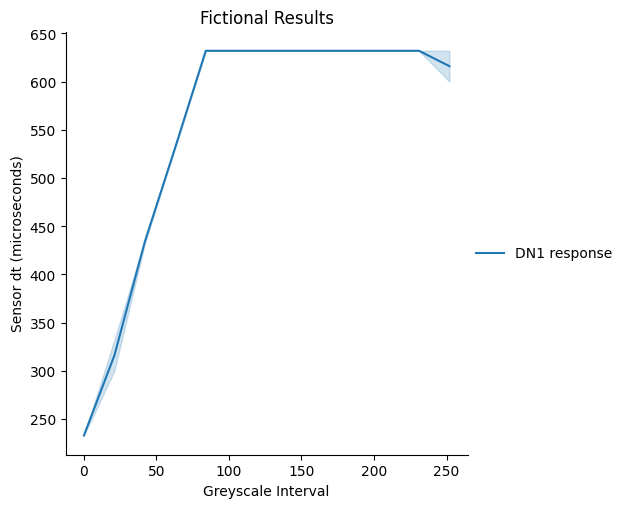

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a line plot with
# the region of error around the line.

# We use numpy to create an array of values
# Panda dataframes want arrays not lists.
import numpy as np

# We will use a library called Seaborn to
# make our plot for us, so we import it.
import seaborn as sns

# We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the array
# like the following.
# This allows multiple data entries per
# point on the x axis.
# Columns as:
# [ <greyscale>, <measurement> ]
results_dn1 = np.array(
[ [0, 233],   # you will have 10 repeats for each greyscale
  [0, 233],
  [21, 300],
  [21, 332],
  [42, 436],
  [42, 432],
  [63, 532],
  [63, 532],
  [84, 632],
  [84, 632],
  [105, 632],
  [105, 632],
  [126, 632],
  [126, 632],
  [147, 632],
  [147, 632],
  [168, 632],
  [168, 632],
  [189, 632],
  [189, 632],
  [210, 632],
  [210, 632],
  [231, 632],
  [231, 632],
  [252, 632],
  [252, 600] ] )

# Reformat the data using pandas
results_dn1 = {"DN1 response": pd.Series(results_dn1[:,1], index=results_dn1[:,0]) }
dataframe = pd.DataFrame( results_dn1 );

# We can now plot both datasets at the same time.
# Note, data=combined!
plot = sns.relplot(data=dataframe, kind="line")
plot.set(xlabel ="Greyscale Interval", ylabel = "Sensor dt (microseconds)", title ='Fictional Results')

<hr><br><br><br><br>

## Exercise 5: Multiple Sensors

In the previous two exercises we have worked with one line sensor, `DN1`.  We have collected measurements and inspected the results, validating that the code works.  This has also helped us to understand the performance of the sensor.

In this exercise we will write code to use all the line sensors more easily, this means `DN1`, `DN2`, `DN3`, `DN4` and `DN5`.

To create this functionality, there are two main approaches we can take that both involve creating our own function:

<p align="centre">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/readLineSensor_AB.png?raw=true">
</p>

**(A)**: copy and paste Algorithm 1 code for each sensor, changing the pin assignment.  This would create 5 seperate functions, and we can then name them something like `readLineSensor0()`, `readLineSensor1`, `readLineSensor2`, etc.

**(B)**: write 1 function, and use the argument (input) to the function to select which sensor is being read.  We might call this function `readLineSensor(number)`

In general, it is preferable to use the second case.  One reason for this is because we would write less code overall, and this means there would be less code for bugs (errors) to occur.  For example, if we did copy-and-paste 5 times, and later we realised there was an error, we would need to make sure we changed this in all 5 functions.  It would be easy to forget this, and spend many hours wondering why your robot has odd behaviour.  Do not underestimate how much time programming is spent debugging!  

The below is example code you will need to complete:

```c
#define EMIT_PIN    11    // Documentation says 11.
#define LS_LEFT_PIN ????   // Complete for DN1 pin
#define LS_MIDLEFT_PIN ????   // Complete for DN2 pin
#define LS_MIDDLE_PIN ????   // Complete for DN3 pin
#define LS_MIDRIGHT_PIN ????   // Complete for DN4 pin
#define LS_RIGHT_PIN ????   // Complete for DN5 pin

// Store our pin numbers into an array, which means
// we can conveniently select one later.
// ls(line sensor)_pin
int ls_pins[5] = {LS_LEFT_PIN,
                  LS_MIDLEFT_PIN,
                  LS_MIDDLE_PIN,
                  LS_MIDRIGHT_PIN,
                  LS_RIGHT_PIN };


#define MAX_SAMPLES ????
float results[ MAX_SAMPLES ]; // An array of MAX_SAMPLES length

void setup() {

  // Set some initial pin modes and states
  pinMode( EMIT_PIN, INPUT ); // Set EMIT as an input (off)
  pinMode( ????, INPUT );     // Set line sensor pin to input

  // Start Serial, wait to connect, print a debug message.
  Serial.begin(9600);
  delay(1500);
  Serial.println("***RESET***");

} // End of setup()


void loop() {

  // Collect MAX_SAMPLES readings.
  for( ?????; ??????; ??????) {

    // This calls our new function, which you need
    // to complete below.  As a result, this should read DN1
    // and save the reading into results[i].
    results[i] = readLineSensor( 0 );  
    delay(200);

  }


  // The section below has been completed for you.
  // Use this section to build a similar construct
  // around the code above, so that results[i] is
  // indexed from value 0 to MAX_SAMPLES.
   
  // The robot will be "stuck" here forever, because
  // the condition true will never change.
  // Therefore, the robot will Serial Print the
  // results back to your computer every 1000ms.
  while( true ) {
      Serial.println("Results: ");
      for( int i = 0; i < MAX_SAMPLES; i++ ) {
        Serial.println( results[i] );
      }
      delay(1000);
  }

} // End of loop()


// A function to read a line sensor.
// Specify which sensor to read with number.
// Number should be a value between 0 and 4
float readLineSensor( number ) {

    // These two if statements should be
    // completed to prevent a memory error.
    // What would be a good value to return that
    // would not be mistaken for a sensor reading?
    if( number < 0 ) {
        return ?????;
    }
    if( number > 4 ) {
        return ?????;
    }


    // Complete the steps referring to the pseudocode block
    // Algorithm 1.
    // The first steps have been done for you.
    // Fix parts labelled ????
    // Some steps are missing - add these.
    pinMode( EMIT_PIN, OUTPUT );
    digitalWrite( EMIT_PIN, HIGH );

    // In this line, we retrieve the pin value
    // stored in the array "ls_pins" at location
    // "number".  So it is like a look-up table.
    // We can think of ls_pins in memory like:
    // Index 0, Index 1, Index 2, Index 3, Index 4
    //[  DN1  ][   DN2 ][  DN3  ][  DN4  ][  DN5  ]
    pinMode( ls_pins[ number ], OUTPUT );

    digitalWrite( ????, HIGH );
    delayMicroseconds( 10 );
  
  
    unsigned long start_time = micros();

    while( digitalRead( ???? ) == ???? ) {
        // Do nothing here (waiting).
    }

    unsigned long end_time = ?????;

    pinMode( ?????, INPUT );

    unsigned long elapsed_time = end_time - start_time;

    // Give the result back to wherever this
    // function was called from.
    return (float)elapsed_time;
}
```

1. In the above example code for `readLineSensor(number)`, the function begins with two if statements to capture an error condition.
  - **Hypothesise:** what do you predict would happen if we did not catch this error, and a value such as `5` was passed into the function?
  - **Hypothesise:** given what we have understood about the sensor readings from Exercises 1 and 2, what would be a good value to return that would not be mistaken as a sensor reading?
  - **Validate:** Test your code by passing a value of `5` to `readLineSensor()`, and also use `Serial.println()` to report to you that an incorrect value was caught.

2. Complete the above example code, replacing all areas marked `????` and adding in any missing lines of code.  
  - Most of these can be drawn from your solutions for Exercise 1 and Exercise 2.
  - You will need to look up the other Arduino pins for line sensors `DN2`, `DN3`, `DN4`, `DN5`.  The correct documentation page is <a href="https://www.pololu.com/docs/0J83/5.9">3Pi+ Pin Assignments</a>.
  - It will help significantly if you comment your own code to explain each step, and you can then compare this against the pseudocode to check your code is complete.

3. Repeat the last part of Exercise 2 (graphing results) for each of the remaining sensors `DN2`, `DN3`, `DN4`, `DN5`.  
  - In **Assessment 2**, you will likely recieve a higher mark for plotting and discussing the distribution on your results, because we can learn more and communicate more this way.  The following example provides the tools for you to do this.
  - There is an updated Python example below that includes arrays for the other sensors, so that you can have multiple plots on one graph.
  - Remember to work-smart-not-hard:
    - Adapt your code to take a measurement from each sensor, and then report them via `Serial.print` in the format of `[ <greyscale index], DN1, DN2, DN3, DN4, DN5 ],`
    - You can then easily copy-and-paste the output into the Python code below.
  - **Validate:** check that all your sensors are working as you would expect.  
    - It is normal to see some difference between the sensors.  This is primarily because of variability in the manufacturing process.


<ipython-input-5-7bdc90a324ed>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append( pd.DataFrame( results_dn2 ) );
<ipython-input-5-7bdc90a324ed>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append( pd.DataFrame( results_dn3 ) );
<ipython-input-5-7bdc90a324ed>:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append( pd.DataFrame( results_dn4 ) );
<ipython-input-5-7bdc90a324ed>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append( pd.DataFrame( results_dn5 ) );


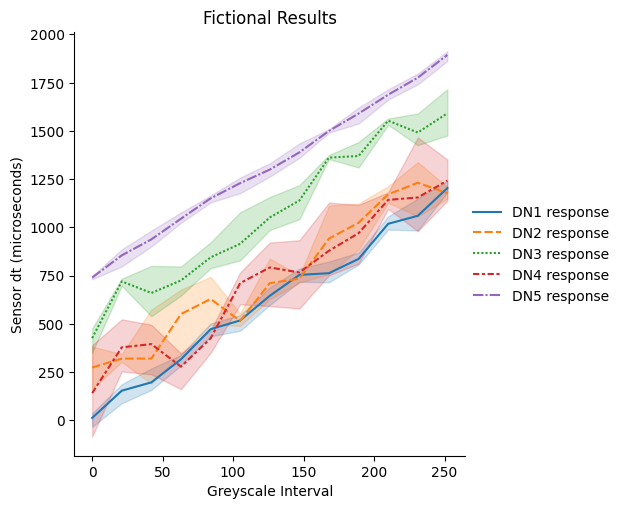

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a line plot with
# the region of error around the line.

# We use numpy to create an array of values
# Panda dataframes want arrays not lists.
import numpy as np

# We will use a library called Seaborn to
# make our plot for us, so we import it.
import seaborn as sns

# We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the array
# like the following.
# This allows multiple data entries per
# point on the x axis.
# Columns as:
# [ <greyscale>, <dn1>, <dn2>, etc ]
results = np.array(
[
[0, 36, 382, 350, 117, 741],
[0, 34, 163, 476, -84, 731],
[0, -34, 275, 452, 389, 747],
[21, 185, 343, 697, 253, 886],
[21, 88, 322, 722, 523, 881],
[21, 187, 294, 740, 358, 797],
[42, 269, 196, 539, 238, 901],
[42, 163, 190, 640, 451, 983],
[42, 157, 573, 800, 495, 929],
[63, 284, 342, 797, 161, 1077],
[63, 338, 677, 646, 327, 1034],
[63, 326, 632, 731, 346, 1023],
[84, 502, 495, 823, 349, 1156],
[84, 435, 743, 922, 465, 1165],
[84, 479, 648, 788, 459, 1129],
[105, 545, 489, 837, 601, 1258],
[105, 464, 501, 1078, 765, 1177],
[105, 543, 554, 829, 766, 1252],
[126, 649, 666, 986, 863, 1263],
[126, 598, 628, 1157, 592, 1332],
[126, 688, 838, 1010, 921, 1303],
[147, 718, 739, 1156, 786, 1435],
[147, 786, 713, 1219, 579, 1360],
[147, 756, 750, 1042, 933, 1370],
[168, 749, 954, 1354, 1128, 1482],
[168, 823, 758, 1355, 757, 1508],
[168, 715, 1113, 1375, 751, 1509],
[189, 869, 1123, 1357, 1116, 1621],
[189, 807, 885, 1310, 812, 1610],
[189, 833, 1063, 1442, 981, 1538],
[210, 1057, 1172, 1564, 1120, 1662],
[210, 988, 1128, 1563, 1211, 1685],
[210, 1010, 1213, 1531, 1096, 1715],
[231, 1149, 1338, 1590, 1466, 1797],
[231, 1046, 1056, 1458, 980, 1789],
[231, 984, 1299, 1426, 1018, 1741],
[252, 1188, 1174, 1581, 1138, 1906],
[252, 1182, 1209, 1476, 1238, 1913],
[252, 1241, 1149, 1716, 1351, 1862]
 ] )

# Reformat the data using pandas
# Use column 0 as the index (x axis)
# Use column n for each sensor value (y axis)
results_dn1 = {"DN1 response": pd.Series(results[:,1], index=results[:,0]) }
results_dn2 = {"DN2 response": pd.Series(results[:,2], index=results[:,0]) }
results_dn3 = {"DN3 response": pd.Series(results[:,3], index=results[:,0]) }
results_dn4 = {"DN4 response": pd.Series(results[:,4], index=results[:,0]) }
results_dn5 = {"DN5 response": pd.Series(results[:,5], index=results[:,0]) }
dataframe = pd.DataFrame( results_dn1 );
dataframe = dataframe.append( pd.DataFrame( results_dn2 ) );
dataframe = dataframe.append( pd.DataFrame( results_dn3 ) );
dataframe = dataframe.append( pd.DataFrame( results_dn4 ) );
dataframe = dataframe.append( pd.DataFrame( results_dn5 ) );



# produce the plot
plot = sns.relplot(data=dataframe, kind="line")
plot.set(xlabel ="Greyscale Interval", ylabel = "Sensor dt (microseconds)", title ='Fictional Results')

<hr><br><br><br><br>

##Exercise 6: LineSensor class

In the previous exercises you should have first of all developed some code to read the line sensor `DN1` within `loop()`, and then refactored this code into a function to call from `loop()` instead.  In this exercise, we will refactor once more to collect our line sensor variables and functions within a class.   

1. Working with the <a href="https://github.com/paulodowd/EMATM0054_22-23/tree/main/3PI_CodeStub">code stub available on Github</a>, move your functions and variables into the `linesensor.h` source code file.
  - Copy across any pin defintions, such as `#define LS_LEFT_PIN`.  You can place these outside the class, but within the linesensor.h file.
  - Where you have used global variables in the above exercises, these can now go at the top level within your class (effectively, global within your class).

2.  Adapt your main Arduino file to:
  - Add `#include "linesensor.h"` to the top of your main Arduino sketch.
  - create an instance of your class as a global variable.
  - initialise your class within `setup()`
  - make calls to your class functions within `loop()`.

You code should look something like the below:

```c
#include "linesensor.h"

LineSensor_c line_sensors;

void setup() {

  // Call a function to setup your class
  // variables etc.
  line_sensors.initialise();

}
  
void loop() {

    // read and report each sensor
  // as comma seperated values to view
  // on the plotter.
  for( int i = 0; i < 5; i++ ) {

    // This line calls a function within your class
    // and stores the returned value.
    float reading = line_sensors.readLineSensor( i );

    Serial.print( reading );
    Serial.print(", ");
  }

  Serial.println(""); // to create a new line.

}
```

<hr><br><br><br><br>

# Multi-tasking with millis()

In this final section, we will take what we have learnt about operating the line sensors with `micros()` and develop a new general technique to help organise which tasks the 3Pi+ robot will run and when.  

So far in our software for the 3Pi+ we have written all our code within the `loop()`.  We have written this code to execute on every iteration.  In the examples, you may have noticed the following line at the bottom of `loop()`:

```c
  // A short delay to keep the timing
  // of this code consistent for now.
  delay(100);
```
Here, `delay(100)` has been used to create a consistent timing for the `loop()` execution.  In general, it is useful to attempt to make your program execution as predictable as possible.  Most often, we will evaluate our robotic system `empirically` - meaning, through observation of it's activity.  If our software is unpredictable, it becomes very difficult to understand what the robot is doing, or to diagnose any faults.  From software alone, theory or logic can not reveal the performance of the robot.  Our robotic system is `situated` and `embedded` within the environment - we expect the robot and the environment to necessarily interact to produce useful behaviours.  

However, the `delay()` function is code which `blocks` execution.  The Arduino Reference states:
> No other reading of sensors, mathematical calculations, or pin manipulation can go on during the delay function, so in effect, it brings most other activity to a halt.

Using `delay()` means that our robot essentially stops processing for the requested interval.   Obviously, this would mean our robot might not be able to respond to a change in the environment.  When we have used `delay(100)` (halting execution for 100 milliseconds), we have essentially forced `loop()` to execute at a slow rate of 10 times a second (10hertz, 10hz).  Remember that `loop()` is not called again until the `loop()` function itself finishes (returns).  

An obvious solution might be to remove the `blocking` function `delay()`.  However, now our `loop()` will execute in an uncontrolled way (as fast as it can).  Whilst it might seem like a good thing to try to get `loop()` to run as fast as possible by having everything happen sequentially one after the other, in reality your program will become very large and complicated.  This means that the timing of `loop()` may change per iteration depending on which code has been run.  As we have observed with our line sensor measurement process - the timing of the code can vary.  This might seem like a minor issue, but it will become significant as the complexity of your program (and robot behaviour) increases.  

In the future, we might have a number of tasks to update within `loop()`, for example:
- reading the line sensors
- updating the line following behaviour
- measuring the angular velocity of the wheels
- calculating a feedback signal for the motor control
- calculating odometry to track the robot position
- monitoring the robot progress through the series of tasks
- reporting debug information back to you
- etc.

Each of the above subtasks will have a different level of priority within the system.  We can also ask ourselves which subtasks need to be responded to quickly, and which others can be updated slowly. For example:
- **fast reponse:** responding to changes in the position of the line under the robot.  If we don't update this quickly enough, the robot might lose track of the line.  
- **slow response:** updating the tracking of the robot progress through the whole line following challenge.  Transitions through desired behaviours might necessarily be slow - e.g., we might permit the robot to come off the line for 3 seconds before we consider it "lost".  

If we can instead schedule subtasks in time, we can improve our code with the following rationale:
- subtasks that do not require high frequency updates can be given an infrequent execution, which means they do not consume computing resources on the remaining `loop()` cycles.
- your code can be organised with a regular update cycle that takes account for operations with `non-deterministic` execution - such as the known variability of time for the line sensor reading process.  
- the readability of your code can be improved, because it will be clear what parts of the program are executing when - as opposed to a long sequential script with no `flow control` (<a href="https://en.wikipedia.org/wiki/Control_flow#:~:text=In%20computer%20science%2C%20control%20flow,from%20a%20declarative%20programming%20language.">control of flow</a>).


## Example:

```c
#include "motors.h"
#include "linesensors.h"

// Global definition of the time interval
#define LINE_SENSOR_UPDATE 100
#define MOTOR_UPDATE       2000

// Timestamps for different contexts.
// We will use _ts to show we are using
// this variable as a timestamp.  We will
// record time in a timestamp, so that we
// can work out how much time has elapsed.
unsigned long motor_ts;    
unsinged long line_sensor_ts;

LineSensor_c line_sensors; // Line sensor variables/functions
Motors_c motors;           // Motor variables/functions

bool travel_direction;  // to toggle the direction of travel

void setup() {

  line_sensors.intialise();
  motors.initialise();

  // Set initial direction
  travel_direction = false;

  // Set initial timestamp values
  motor_ts       = millis();
  line_sensor_ts = millis();
}

void loop() {

  // Record the time of this execution
  // of loop for coming calucations
  //  ( _ts = "time-stamp" )
  unsigned long current_ts;
  current_ts = millis();


  // Run our line sensor update
  // every 100ms (10hz).
  // Tracking time for the line sensor (ls)
  elapsed_t = current_ts - line_sensor_ts;
  if( elapsed_t > LINE_SENSOR_UPDATE ) {
      
      // Conduct a read of the line sensor DN1
      line_sensors.readLineSensor(0);

      // Record when this execution happened.
      // for future iterations of loop()
      line_sensor_ts = millis();

  }

  // Just to test this process:
  // Alternate the motor direction
  // every 2 seconds so that the 3Pi+
  // drives fowards, then backwards.
  elapsed_t = current_ts - motor_ts;
  if( elapsed_t > MOTOR_UPDATE ) {
      // Record when this execution happened
      // for future iterations of loop()
      motor_ts = millis();


      // Toggle motor direction
      if( travel_direction == false ) {
         travel_direction = true;
      } else {
         travel_direction = false;
      }

  }


  // Currently going forwards or backwards?
  // This is checked every loop(), but the state
  // of travel_direction is only changing every
  // MOTOR_UPDATE ms.
  if( travel_direction == true ) {
    motors.setMotorPower( 50, 50 );
  } else {
    motors.setMotorPower( -50, -50 );
  }

  // Delay no longer being used.
  // delay(100)

}


```

In the above example, you should be able to recognise the familiar form of the following code:
```c
  elapsed_t = current_ts - line_sensor_ts;

  elapsed_t = current_ts - motor_ts;
```

This follows the same principle we have used for the line sensor measurement, the time for the capacitor to discharge (except, we are now using `millis()`):
<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/time_elapsed.png?raw=true">
</p>

In the above example, `current_ts` is $t_{2}$, or the current time that `loop()` is executing.  `ls_ts` (line-sensor time-stamp) and `motor_ts` (motor time-stamp) are **historic** values of time, or $t_{1}$.  We use the time since $t_{1}$ to only update the motors or line-sensors once a defined period of time has elapsed.  

When the correct time has elapsed, it is necessary to advance the value of $t_{1}$ (the historic value) to the current time, so that the code does not execute again until the correct amount of time has elapsed once more.  We can observe this operation in the following two lines of code, for each subtask:

```c
      // Record when this execution happened.
      // for future iterations of loop()
      line_sensor_ts = millis();
```

```c
      // Record when this execution happened
      // for future iterations of loop()
      motor_ts = millis();
```

If this is still confusing, it is recommended to draw a timeline on paper, and to follow the code procedure by hand, drafting a table of values for $t_{elapsed}$, $t_{1}$ and $t_{2}$ with respect to time in the context of either the motor or line sensor schedule tasks.  



<hr><br><br><br><br>

# Further Work

**It is advised that you come back to this section of the exercise sheet in the future.  This section has some advanced exercises to make minor improvements to your code.  This section is not essential to solve the Assessment 1 coursework.
 In this section, optimising your code might save 6milliseconds of code execution - which is not much in the long run.  This section should provide a good challenge for students looking to progress their skills further.**  

A simple solution to read all 3 central line sensors would be to repeat the above procedure sequentially, one after the other, for each sensor `DN2`, `DN3` and `DN4`.  

You might even be inclined to "copy and paste" your code, changing the pin numbers for each instance.  

However, intuitively, this would mean that the overall time taken to update the sensors would be the sum of the time for each to complete in sequence.  This is not efficient, and it is generally undesirable that our robot should be waiting for something to finish.  

<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_LS_SerialRead.png?raw=true">
</p>

Instead, we can conduct the read process in parallel by setting the appropriate pins, and recording an elapsed time for each sensor concurrently as they complete:  

<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_LS_ParallelRead.png?raw=true">
</p>


In the above, we can also imagine this as setting up all sensors to begin reading (charge the capacitors), and then to iterate (poll) each sensor sequentially to see if the discharging (reading) has completed.  By doing it this way, the total time taken to read the sensor will be only the longest sensor to read.  The following pseudocode describes the process algorithmically:

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/Algo3_PseudoParallelRead.png?raw=true">
</p>


## Exercise 7: Pseudo-Parallel Line Sensor Reading

1. Translate the above pseudocode block into a function within your own source code.
  - Remember that you can do this in addition to any existing code you have written for the line sensors.

2. In the pseudocode, line 15 says: "**if** $Sensor_{n}$ has not finished before":
  - Why would this conditional statement be necessary?  What bug might be caused without it?
  - **Hint:** Line 18 would be a part of the bug caused.
  - How could we implement a check of whether a sensor has completed reading on a previous occasion?  There are many solutions to this problem.

3. The above pseudocode has a potential problem.  If anyone of the sensors does not complete reading, your 3Pi+ robot would be stuck executing the `while` loop on line 12.  
  - Implement a timeout feature to prevent this blocking error.
  - Decide what value should be assigned to each sensor in the event of a timeout situation.

4. You should now have two different ways to read the line sensors (one using the ADC, and one measuring the time to discharge).  
 - Measure how long each one takes to complete.  How do they compare?
 - Evaluate the range of readings for each.  What are the implications for **sensitivity**?
 - Evaluate the variance of each - which appears to have more **noise**?
 - The best way to evaluate these aspects is to produce graphical plots with a distribution indicated.

<hr><br><br><br><br>